In [1]:
import sys
sys.path.append("..")
from BiokeyData import *
import credentials
import os

In [2]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
% matplotlib inline

# Load Data
Load data in using BiokeyData package.

In [4]:
data = BiokeyData(credentials.postgres)
all_dwells = data.get_dwells()

Loading Data
	- Attempting cache load
	- Missed stroke cache
	- Done and cached for later
Processing Data
	- Attempting cache load
	- Missed dwell and flight cache


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Loading Data', max=15), HTML(value='')))


	- Done and cached for later
Done Loading



In [5]:
selected_user = '1d63b44d-a7cb-4ee6-b228-b0ff5b7d086f'
thresh = 10 * 60 * 1000

# Plot User Sequences
Plot user sequences to visualize sequence length

In [6]:
def user_sequence_label(dwells, thresh):
    dwells = dwells.sort_values('down')
    dwells['Interval'] = (dwells.down - dwells.up.shift(1)).fillna(0)
    dividers = dwells.Interval > thresh
    dwells['Sequence'] = dividers.cumsum()
    return dwells

def user_sequence_split(dwells, thresh):
    return user_sequence_label(dwells, thresh).groupby('Sequence').apply(lambda x: pd.Series({
        'start': x.down.min(), 
        'finish': x.up.max(), 
        'duration': x.up.max() - x.down.min()
    }))

def get_sequences(dwells, thresh):
    return dwells.groupby('user_id').apply(lambda x: user_sequence_split(x, thresh)).reset_index()

def plot_sequences(dwells, thresh):
    seqs = get_sequences(dwells, thresh)
    return plt.barh(seqs.user_id, width=seqs.duration,left=seqs.start)

## Sequence Timeline
Timeline of sequences that meet threshold. Dataset will be a combination of non-overlapping users sets, labelled whether it is the user.

<Container object of 2762 artists>

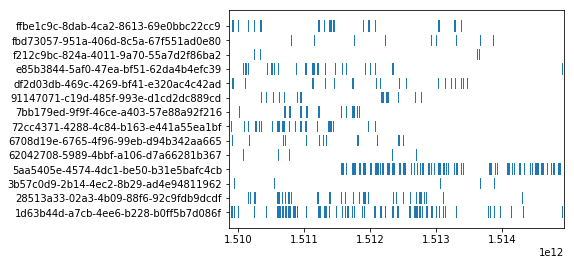

In [7]:
plot_sequences(all_dwells, thresh)

## Sequence Duration Breakdown
This is just to invastigate how long the sequences are and how sparse each user's sequences are.

In [8]:
seqs = get_sequences(all_dwells, thresh)
# Add in sequence numbers
all_dwells = all_dwells.groupby('user_id').apply(lambda x: user_sequence_label(x, thresh))
all_dwells = all_dwells.reset_index(drop=True).sort_values('down')

In [9]:
durations = seqs.groupby(['user_id', 'Sequence']).agg({'duration': 'sum'})
# Change: groupby state_office and divide by sum
duration_pcts = durations.groupby(level=0).apply(lambda x: x / float(x.sum()))

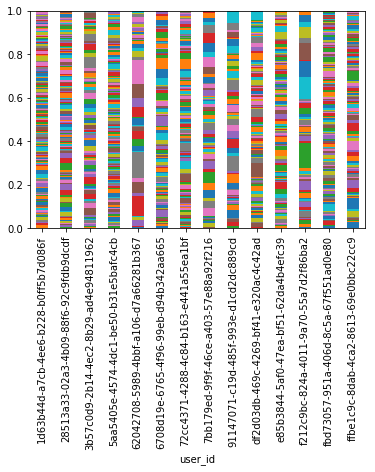

In [10]:
duration_pcts.unstack('Sequence').fillna(0).plot(kind='bar', stacked=True, legend=False)

# Sample Sequences
How to sample the sequences on a per-user basis

In [10]:
selected_seqs = duration_pcts.reset_index().groupby('user_id').apply(lambda x: x.sample(frac=0.5).set_index('Sequence')).index

In [11]:
sampled_seqs = seqs.set_index(['user_id', 'Sequence']).loc[selected_seqs].sort_values('start').reset_index()

## Plot Sample of Sequences
Plot the samples for good measure

<Container object of 1066 artists>

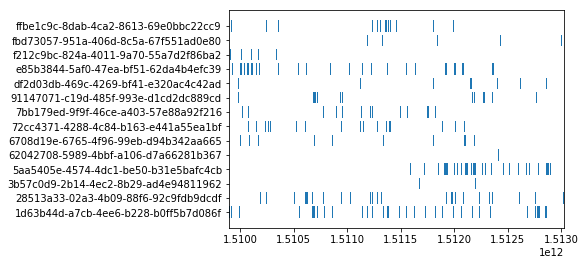

In [12]:
plt.barh(sampled_seqs.user_id, width=sampled_seqs.duration,left=sampled_seqs.start)

# Create Train and Test Sets
Code to generate train and test sets, splitting data on a per user basis and mixing in sequences from other users in blank spots.

In [11]:
def get_user_set(selected_user, sampled_seqs, seqs, all_dwells):
    # Select the user's sequences from their sampled sequences and calculate the range of time they cover
    users_seqs = sampled_seqs.loc[sampled_seqs.user_id == selected_user].sort_values('start')
    ranges_to_fill = pd.DataFrame({'start': users_seqs.finish, 'finish': users_seqs.start.shift(-1)})
    # Select all other sequences that fit within the spaces from other users
    non_user_seqs = sampled_seqs.loc[sampled_seqs.user_id != selected_user].sort_values('start')
    to_include = pd.concat([non_user_seqs.loc[(non_user_seqs.start > x.start) & (non_user_seqs.finish < x.finish)] for i, x in ranges_to_fill.iterrows()], ignore_index=True)
    # Merge both values and assure no overlap
    set_sequences = pd.concat([users_seqs, to_include], ignore_index=True).sort_values('start').reset_index()
    set_sequences = set_sequences.loc[set_sequences.start.shift(-1) - set_sequences.finish > 0]
    # Select dwells chosen as part of selected training sequences
    set_indexes = set_sequences[['user_id', 'Sequence']].set_index(['user_id', 'Sequence']).index
    set_dwells = all_dwells.set_index(['user_id', 'Sequence']).loc[set_indexes].reset_index().sort_values('down')
    # Return the bare bones features
    return pd.DataFrame({
        'key_code': set_dwells.key_code,
        'down': set_dwells.down,
        'up': set_dwells.down,
        'dwell': set_dwells.dwell,
        'is_user': set_dwells.user_id == selected_user,
    }, columns=['key_code', 'down', 'up', 'dwell', 'is_user'])

def get_user_split_sets(selected_user, seqs, all_dwells):
    # Select random sample of each user's sequence
    selected_seqs = seqs.groupby('user_id').apply(lambda x: x.sample(frac=0.5).set_index('Sequence')).index
    # Select the actual sequence from the indexes and generate a train set with it
    sampled_seqs = seqs.set_index(['user_id', 'Sequence']).loc[selected_seqs].sort_values('start').reset_index()
    train = get_user_set(selected_user, sampled_seqs, seqs, all_dwells)
    # Select the opposite sequences and generate a test set with it
    sampled_seqs = seqs.set_index(['user_id', 'Sequence']).drop(selected_seqs).sort_values('start').reset_index()
    test = get_user_set(selected_user, sampled_seqs, seqs, all_dwells)
    # Return both sets
    return {'train': train, 'test': test}

Generate a test and train set for each user

In [12]:
datasets = {user: get_user_split_sets(user, seqs, all_dwells) for user in all_dwells.user_id.unique()}

In [13]:
datasets[selected_user]['test'].head(10)

,key_code,down,up,dwell,is_user
0,47,1509858869909,1509858869909,60,True
1,18,1509858870179,1509858870179,176,True
2,34,1509858870636,1509858870636,133,True
3,18,1509858871213,1509858871213,124,True
4,30,1509858871831,1509858871831,64,True
5,47,1509858871970,1509858871970,92,True
6,18,1509858872076,1509858872076,112,True
7,19,1509858872173,1509858872173,63,True
8,30,1509858872305,1509858872305,36,True
9,34,1509858872417,1509858872417,102,True


Output all of the files to the user's respective folder

In [15]:
for user in datasets:
    user_directory = 'output/users/{0}'.format(user)
    if not os.path.exists(user_directory):
        os.makedirs(user_directory)
    datasets[user]['train'].to_csv('{0}/train.csv'.format(user_directory), index=False)
    datasets[user]['test'].to_csv('{0}/test.csv'.format(user_directory), index=False)

# Original Split

In [31]:
selected_user = '1d63b44d-a7cb-4ee6-b228-b0ff5b7d086f'

users_seqs = sampled_seqs.loc[sampled_seqs.user_id == selected_user].sort_values('start')
ranges_to_fill = pd.DataFrame({'start': users_seqs.finish, 'finish': users_seqs.start.shift(-1)})

non_user_seqs = seqs.loc[seqs.user_id != selected_user].sort_values('start')
to_include = pd.concat([non_user_seqs.loc[(non_user_seqs.start > x.start) & (non_user_seqs.finish < x.finish)] for i, x in ranges_to_fill.iterrows()], ignore_index=True)

train_sequences = pd.concat([users_seqs, to_include], ignore_index=True).sort_values('start').reset_index()
train_sequences = train_sequences.loc[train_sequences.start.shift(-1) - train_sequences.finish > 0]

<Container object of 1039 artists>

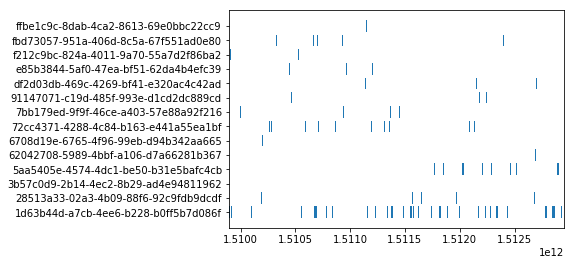

In [32]:
plt.barh(train_sequences.user_id, width=train_sequences.duration,left=train_sequences.start)

In [33]:
# Add in sequence numbers
all_dwells = all_dwells.groupby('user_id').apply(lambda x: user_sequence_label(x, thresh))
all_dwells = all_dwells.reset_index(drop=True).sort_values('down')

In [34]:
# Select dwells chosen as part of selected training sequences
training_indexes = train_sequences[['user_id', 'Sequence']].set_index(['user_id', 'Sequence']).index
training_dwells = all_dwells.set_index(['user_id', 'Sequence']).loc[training_indexes].reset_index().sort_values('down')

In [35]:
training_dwells.count()/all_dwells.count()

Interval    0.190309
Sequence    0.190309
down        0.190309
dwell       0.190309
key_code    0.190309
up          0.190309
user_id     0.190309
dtype: float64

In [36]:
training_set = pd.DataFrame({
    'key_code': training_dwells.key_code,
    'down': training_dwells.down,
    'up': training_dwells.down,
    'dwell': training_dwells.dwell,
    'is_user': training_dwells.user_id == selected_user,
}, columns=['key_code', 'down', 'up', 'dwell', 'is_user'])

In [37]:
training_set.head(10)

,key_code,down,up,dwell,is_user
0,3675,1509893289951,1509893289951,264,True
1,20,1509893290039,1509893290039,68,True
2,50,1509893290477,1509893290477,170,True
3,18,1509893290601,1509893290601,85,True
4,31,1509893290795,1509893290795,93,True
5,50,1509893292174,1509893292174,62,True
6,18,1509893292240,1509893292240,88,True
7,31,1509893292370,1509893292370,103,True
8,28,1509893292728,1509893292728,91,True
9,3675,1509893296316,1509893296316,362,True
